In [2]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import json 


In [3]:
# path du dossier d'annotation
!git clone https://github.com/rsebai/animals.git

path = "animals/labelled/"

annotations_folder_path = Path(path)

Cloning into 'animals'...
remote: Enumerating objects: 50486, done.
remote: Counting objects: 100% (50486/50486), done.
remote: Compressing objects: 100% (49447/49447), done.
remote: Total 50486 (delta 1054), reused 50466 (delta 1037), pack-reused 0
Receiving objects: 100% (50486/50486), 77.15 MiB | 24.14 MiB/s, done.
Resolving deltas: 100% (1054/1054), done.
Checking out files: 100% (50786/50786), done.


## Parsing files to arrays 

In [4]:
def read_content(xml_file):
    """
    formats data from xml to arrays.
    returns image name, boxes position, classes labels
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    filename = root.find('filename').text

    
    if root.find('object') is None:
        list_with_all_boxes = [[None,None, None, None]]
        list_with_all_labels = [None]
    else:
        list_with_all_boxes = []
        list_with_all_labels = []
        for boxes in root.iter('object'):
            ymin, xmin, ymax, xmax = None, None, None, None

            ymin = int(boxes.find("bndbox/ymin").text)
            xmin = int(boxes.find("bndbox/xmin").text)
            ymax = int(boxes.find("bndbox/ymax").text)
            xmax = int(boxes.find("bndbox/xmax").text)

            list_with_single_boxes = [xmin, ymin, xmax, ymax]
            list_with_all_boxes.append(list_with_single_boxes)

            label = boxes.find("name").text
            list_with_all_labels.append(label)

    # add image width and height if needed
        
    return [filename]*len(list_with_all_labels), list_with_all_boxes, list_with_all_labels

In [5]:
def read_content_json(json_file):
    """
    formats data from xml to arrays.
    returns image name, boxes position, classes labels
    """
    tree = ET.parse(json_file)
    root = tree.getroot()
    
    filename = root.find('filename').text

    
    if root.find('object') is None:
        list_with_all_boxes = [[None,None, None, None]]
        list_with_all_labels = [None]
    else:
        list_with_all_boxes = []
        list_with_all_labels = []
        for boxes in root.iter('object'):
            ymin, xmin, ymax, xmax = None, None, None, None

            ymin = int(boxes.find("bndbox/ymin").text)
            xmin = int(boxes.find("bndbox/xmin").text)
            ymax = int(boxes.find("bndbox/ymax").text)
            xmax = int(boxes.find("bndbox/xmax").text)

            list_with_single_boxes = [xmin, ymin, xmax, ymax]
            list_with_all_boxes.append(list_with_single_boxes)

            label = boxes.find("name").text
            list_with_all_labels.append(label)

    # add image width and height if needed
        
    return [filename]*len(list_with_all_labels), list_with_all_boxes, list_with_all_labels

## !! path = chemin du dossier des annotations

In [35]:
# load the training data set (entirely or partly)
image_ids = np.array([])
box = np.empty((0,4))
label = np.array([])

for file in tqdm(list(annotations_folder_path.glob('*.xml'))):
    annot = read_content(file)
    image_ids = np.append(image_ids,annot[0])
    box = np.concatenate([box,annot[1]])
    label = np.append(label,annot[2])

for file_json in list(annotations_folder_path.glob("*.json")):
    with open(file_json) as json_data:
        data = json.load(json_data)
        for i in range(len(data['shapes'])):
          image_ids = np.append(image_ids,data['imagePath'])
          flat_list = [item for sublist in data['shapes'][i]['points'] for item in sublist]   
          box = np.concatenate([box,[flat_list]])
          label = np.append(label,data['shapes'][i]['label'])

100%|██████████| 483/483 [00:00<00:00, 7861.70it/s]


In [36]:
# create the training dataframe
X = pd.DataFrame(image_ids,columns=['image_ids'])
# X = pd.DataFrame(box,columns=['xmin', 'ymin', 'xmax', 'ymax'])
X[['xmin', 'ymin', 'xmax', 'ymax']] = box
X['class']=label
X.shape

(888, 6)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

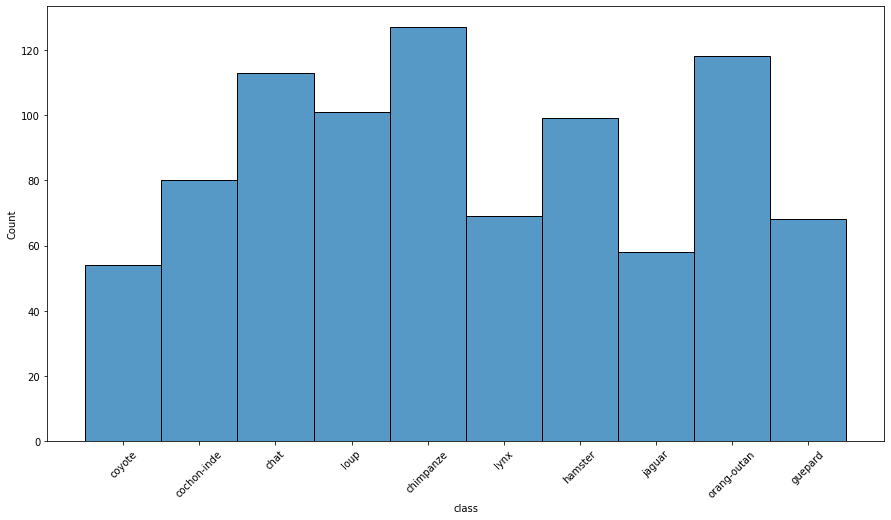

In [37]:
plt.figure(figsize = (15,8))
ax = sns.histplot(X['class'])
plt.xticks(rotation=45)